In [1]:
import sys, os
sys.path.append('/home/san/dp3/vggt')
from vggt.models.vggt import VGGT

import torch 

In [2]:
def load_vggt(device="cuda"):
    v = VGGT()
    url = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    v.load_state_dict(torch.hub.load_state_dict_from_url(url))
    v.to(device)
    v.eval()
    vggt_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
    return v, vggt_dtype

In [3]:
from vggt.utils.load_fn import load_and_preprocess_images, preprocess_images
image_names = [os.path.join('/home/san/dp3/3D-Diffusion-Policy/3D-Diffusion-Policy/test_images', path) for path in os.listdir('/home/san/dp3/3D-Diffusion-Policy/3D-Diffusion-Policy/test_images')]
image_names

['/home/san/dp3/3D-Diffusion-Policy/3D-Diffusion-Policy/test_images/test_image_2.png',
 '/home/san/dp3/3D-Diffusion-Policy/3D-Diffusion-Policy/test_images/test_image_0.png',
 '/home/san/dp3/3D-Diffusion-Policy/3D-Diffusion-Policy/test_images/test_image_1.png']

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model, dtype = load_vggt()
  
images = load_and_preprocess_images(image_names).to(device)

In [5]:

with torch.no_grad():
    with torch.amp.autocast('cuda', dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)
        tokens, pos_idx = model.aggregator(images[None])

print(images[0].shape, tokens[0].shape, pos_idx, (518//14)**2)

/home/san/dp3/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


torch.Size([3, 518, 518]) torch.Size([1, 3, 1374, 2048]) 5 1369


In [57]:
1374 - 1369

5

In [58]:
torch.all(predictions['images'] == images)

tensor(True, device='cuda:0')

In [60]:
depth_maps = predictions['depth'][0]
images.shape, depth_maps.shape

(torch.Size([3, 3, 518, 518]), torch.Size([3, 518, 518, 1]))

(1, 3, 3, 518, 518) (1, 3, 518, 518, 1)
(3, 518, 518)


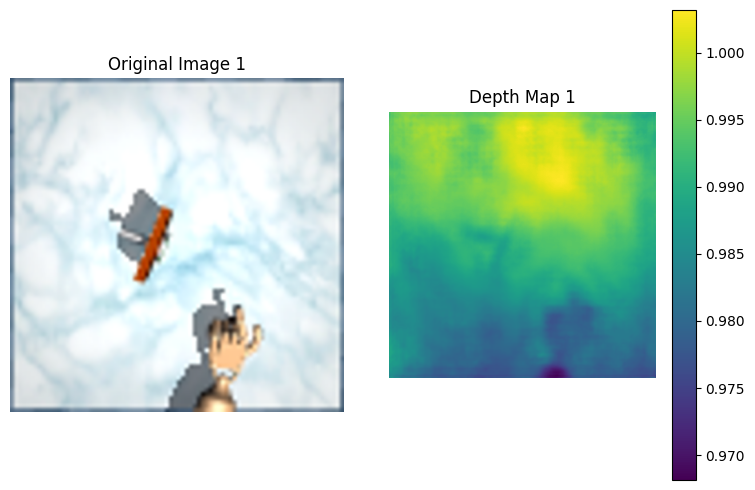

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_and_depth(images, predictions, num_cols=2):
    """Plot RGB images and their corresponding depth maps side by side
    
    Args:
        images: Tensor of shape (B, N, C, H, W) containing RGB images
        predictions: Dictionary containing depth predictions from VGGT model
        num_cols: Number of columns in the plot grid (default 2 for side-by-side)
    """
    # Move tensors to CPU and convert to numpy arrays
    images = predictions['images'].cpu().numpy()
    depth_maps = predictions['depth'].cpu().numpy()
    print(images.shape, depth_maps.shape)
    # Get batch size
    batch_size = images.shape[0]
    
    # Calculate number of rows needed
    num_rows = (batch_size + num_cols - 1) // num_cols
    
    # Create figure
    plt.figure(figsize=(15, 5*num_rows))
    
    for i in range(batch_size):
        # Plot original image
        plt.subplot(num_rows, num_cols*2, i*2 + 1)
        print(images[i,0].shape)
        plt.imshow(np.transpose(images[i,0], (1,2,0)))  # Change from CxHxW to HxWxC
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        
        # Plot depth map
        plt.subplot(num_rows, num_cols*2, i*2 + 2)
        plt.imshow(depth_maps[i,0], cmap='viridis')  # Using viridis colormap for depth
        plt.title(f'Depth Map {i+1}')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_images_and_depth(images, predictions)


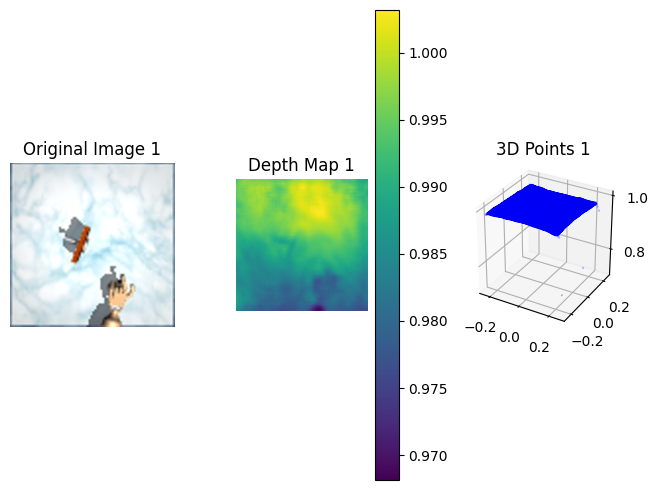

In [62]:
predictions['world_points']
# Get world coordinates and convert to numpy
world_coords = predictions['world_points'].cpu().numpy()

# Update plotting function to include world coordinates
def plot_images_depth_and_points(images, depth_maps, world_coords, num_cols=3):
    """Plot RGB images, depth maps and 3D point clouds side by side"""
    batch_size = images.shape[0]
    num_rows = (batch_size + num_cols - 1) // num_cols
    
    plt.figure(figsize=(20, 5*num_rows))
    
    for i in range(batch_size):
        # Plot original image
        plt.subplot(num_rows, num_cols*3, i*3 + 1)
        plt.imshow(np.transpose(images[i,0], (1,2,0)))
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        
        # Plot depth map
        plt.subplot(num_rows, num_cols*3, i*3 + 2)
        plt.imshow(depth_maps[i,0], cmap='viridis')
        plt.title(f'Depth Map {i+1}')
        plt.colorbar()
        plt.axis('off')
        
        # Plot 3D points
        ax = plt.subplot(num_rows, num_cols*3, i*3 + 3, projection='3d')
        points = world_coords[i].reshape(-1, 3)
        ax.scatter(points[:,0], points[:,1], points[:,2], c='b', marker='.', s=1, alpha=0.1)
        ax.set_title(f'3D Points {i+1}')
        # Set equal aspect ratio
        ax.set_box_aspect([1,1,1])
        
    plt.tight_layout()
    plt.show()

# Plot all three visualizations
plot_images_depth_and_points(
    predictions['images'].cpu().numpy(),
    predictions['depth'].cpu().numpy(), 
    world_coords
)


In [9]:
from torchvision import transforms
import PIL.Image

factor = 1
images_lowres = []
for img_path in image_names:
    img = PIL.Image.open(img_path)
    # Scale down the image by a factor of 2 
    img = transforms.Resize((factor*img.height, factor*img.width))(img)
    img = transforms.ToTensor()(img) # Convert to tensor and rescale to 0-1
    images_lowres.append(img)
images_lowres = torch.stack(images_lowres).to(device)

print(images_lowres.shape)
with torch.no_grad():
    with torch.amp.autocast('cuda', dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions_lowres = model(images_lowres)

torch.Size([3, 3, 84, 84])


(1, 3, 3, 168, 168) (1, 3, 168, 168, 1)
(3, 168, 168)


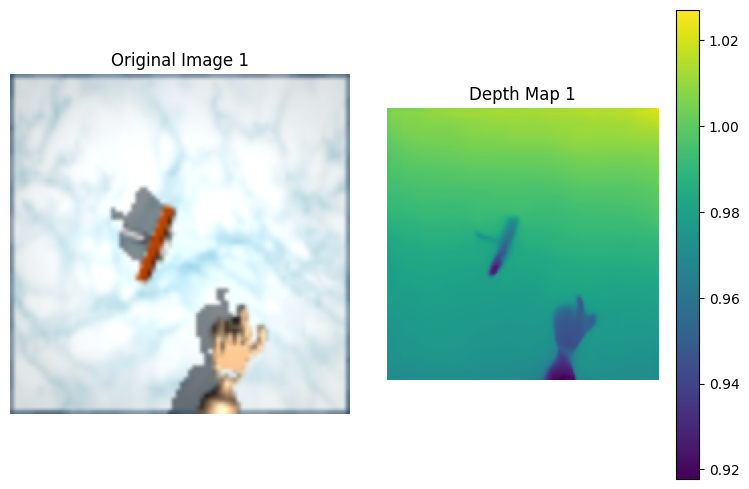

In [8]:

plot_images_and_depth(images_lowres, predictions_lowres)

(1, 3, 3, 84, 84) (1, 3, 84, 84, 1)
(3, 84, 84)


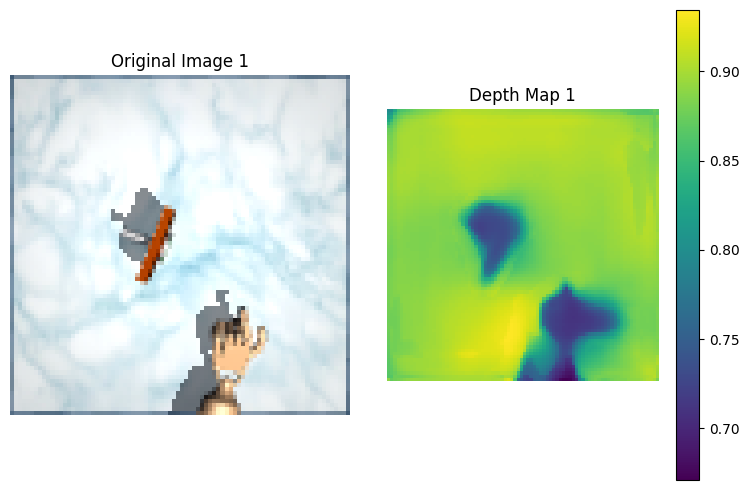

In [10]:

plot_images_and_depth(images_lowres, predictions_lowres)

(1, 3, 3, 252, 252) (1, 3, 252, 252, 1)
(3, 252, 252)


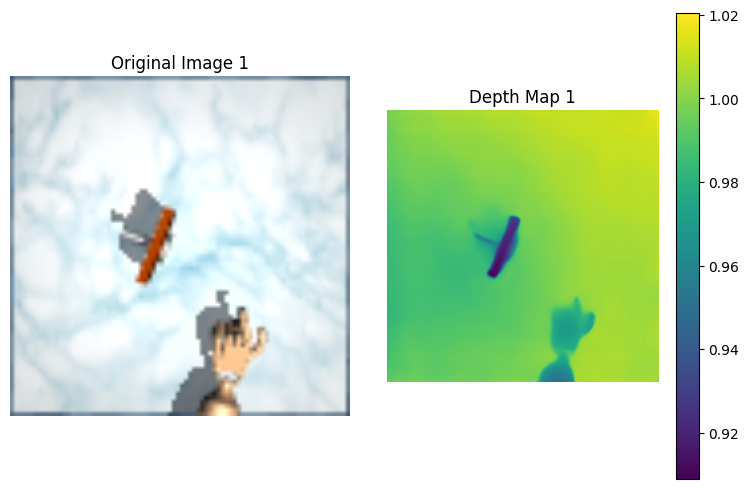

In [66]:
# 84 84 3
plot_images_and_depth(images_lowres, predictions_lowres)

In [67]:
predictions_lowres['world_points']

tensor([[[[[-0.1671, -0.1797,  0.9988],
           [-0.1600, -0.1780,  0.9999],
           [-0.1571, -0.1733,  1.0027],
           ...,
           [ 0.1313, -0.1696,  1.0088],
           [ 0.1384, -0.1723,  1.0065],
           [ 0.1829, -0.1876,  0.7802]],

          [[-0.1661, -0.1736,  0.9971],
           [-0.1604, -0.1706,  1.0016],
           [-0.1567, -0.1689,  1.0030],
           ...,
           [ 0.1314, -0.1649,  1.0092],
           [ 0.1381, -0.1661,  1.0051],
           [ 0.1479, -0.1658,  0.9963]],

          [[-0.1655, -0.1686,  1.0013],
           [-0.1604, -0.1671,  1.0037],
           [-0.1565, -0.1651,  1.0029],
           ...,
           [ 0.1294, -0.1605,  1.0096],
           [ 0.1338, -0.1606,  1.0088],
           [ 0.1413, -0.1596,  1.0054]],

          ...,

          [[-0.1620,  0.1618,  0.9776],
           [-0.1529,  0.1593,  0.9755],
           [-0.1498,  0.1572,  0.9772],
           ...,
           [ 0.1308,  0.1558,  0.9817],
           [ 0.1353,  0.1566,  0.9